In [76]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
import json
from tqdm import tqdm, tqdm_notebook
import os

%run ../Scripts/coverage.py
%run ../Scripts/fitness.py
%run ../Scripts/immunity.py
%run ../Scripts/initMethods.py
%run ../Scripts/supMethods.py
%run ../Scripts/mutation.py

In [78]:
params = { #parameters relevant for the equations
    "Nh":           10E8,
    "N0":            10E7, #This Will be updated by self-consitent solution
    "R0":              20, 
    "M":                1, #Also L, total number of spacers
    "mu":            0.01, #mutation rate
    "gamma_shape":     20, 
    "Np":               0, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":             2000, #cross-reactivity kernel
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                   1000,
    "dx":                           1,
    "tf":                        1000,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_mean_nh":          [0,0],
    "conv_size":                 4000,
    "num_threads":                 32,
    "tail_axis":               [1, 1],
}

In [79]:
params, sim_params = init_cond(params, sim_params)
foldername = "test1/"
try:
    write2json(foldername, params, sim_params)
except FileNotFoundError:
    os.mkdir(foldername)
    write2json(foldername, params, sim_params)


Phage Population: 100000000.0000| Uc: 12.3719| sigma: 2.7195
Phage Population: 667465.8400| Uc: 9.1587| sigma: 2.5226
Phage Population: 574284.5005| Uc: 9.0539| sigma: 2.5153
Phage Population: 570990.3443| Uc: 9.0499| sigma: 2.5150
Phage Population: 570863.5594| Uc: 9.0498| sigma: 2.5150
Phage Population: 570858.6639| Uc: 9.0498| sigma: 2.5150
Phage Population: 570858.4749| Uc: 9.0498| sigma: 2.5150


In [ ]:
n = init_guassian(params["N"], sim_params, "n")
nh = init_exptail(params["Nh"], params, sim_params, "nh")


In [75]:
Nh = params["Nh"]
N0 = params["N0"]
params["N"] = N0

for i in range(100):
    params, sim_params = fill_parameters(params, sim_params)
    N0 = params["N"]
    uc = params["uc"]
    sigma = params["sigma"]
    print(f"Phage Population: {N0:.4f}| Uc: {uc:.4f}| sigma: {sigma:.4f}")

    if np.isnan(uc) or np.isnan(sigma):
        raise(ValueError("You need >10E6 Nh or >10E3 N0"))

    N = Nh*(params["s"]*params["v0"])
    params["N"] = N
    if np.abs(N0-N) <= 0.5:
        params["N"] = int(N)
        params, sim_params = fill_parameters(params, sim_params)
        uc = params["uc"]
        sigma = params["sigma"]
        print(f"Phage Population: {N:.4f}| Uc: {uc:.4f}| sigma: {sigma:.4f}")
        break

Phage Population: 100.0000| Uc: nan| sigma: nan


/Users/zhizhang144515/Documents/CRISPR_Sim/Scripts/initMethods.py:23: RuntimeWarning: invalid value encountered in power
  sigma = np.power(D/s, 1/3)*np.power(common_log, 1/6)
/Users/zhizhang144515/Documents/CRISPR_Sim/Scripts/initMethods.py:24: RuntimeWarning: invalid value encountered in power
  v0 = np.power(s, 1/3)*np.power(D, 2/3)*np.power(common_log, 1/3)


ValueError: You need 10E6 Nh or 10E3 N0

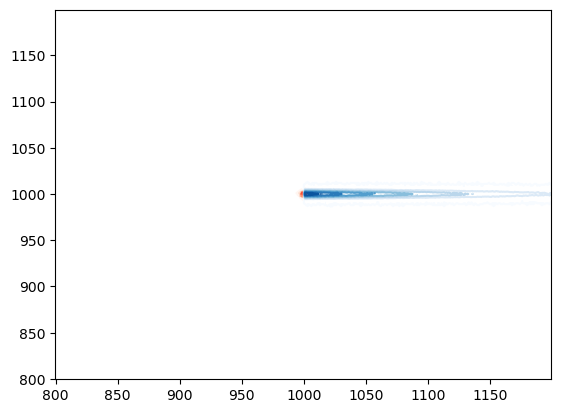

In [59]:
plt.figure()
plt.contour(n.todense(), cmap = "Reds")
plt.contour(nh.todense(), cmap = "Blues")
plt.margins(-0.4, -0.4)
plt.show()

In [ ]:
n = init_guassian(params["N0"], sim_params, "n")
nh = init_exptail(params["Nh"], params, sim_params, "nh")
kernel_quarter = init_quarter_kernel(params, sim_params)

for i in range(sim_params["tf"]):
    sparse.save_npz(foldername+f"sp_frame_n{i}",n.tocoo())
    sparse.save_npz(foldername+f"sp_frame_nh{i}",nh.tocoo())

    p = elementwise_coverage(nh, n, kernel, params, sim_params)
    f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    f = norm_fitness(f, n, params, sim_params) #renormalize f
    n = virus_growth(n, f, params, sim_params) #update

    n = mutation(n, params, sim_params)
    nh = immunity_update(nh, n, params, sim_params) #update nh

In [ ]:
R0_sweep = [20]
kernel = init_quarter_kernel(params, sim_params)
foldername = "test0/"
write2json(foldername, params, sim_params)

for R0 in R0_sweep:
    params["R0"] = R0
    n = init_guassian(params["N"], sim_params, "n")
    nh = init_guassian(params["Nh"], sim_params, "nh")

    for i in range(10000):

        if (i%100 == 0 or i < 20):
            sparse.save_npz(foldername+f"sp_frame_n{i}",n.tocoo())
            sparse.save_npz(foldername+f"sp_frame_nh{i}",nh.tocoo())

        p = elementwise_coverage(nh, n, kernel, params, sim_params)
        f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
        # f = norm_fitness(f, n, params, sim_params)
        n = virus_growth(n, f, params, sim_params) #update

        n = mutation(n, params, sim_params)
        nh = immunity_update(nh, n, params, sim_params) #update nh

        if np.sum(n) >= 10*params["Nh"]:
            break